In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

In [2]:
import numpy as np
import pandas as pd

clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

# Perovskite dataset

We will work with a real dataset, taken from the paper "[New tolerance factor to predict the stability of perovskite oxides and halides](https://advances.sciencemag.org/content/5/2/eaav0693)" by Bartel et al. Perovskites are a very useful class of oxide materials that can have very high catalyic activities, and have recently shown promise in solar cells. However, not all combinations of elements will form a perovskite structure, and it is very useful to be able to predict whether or not an elemental composition will form a perovskite. This helps determine whether or not a material can be synthesized before going into the lab.

This dataset contains a list of chemical formulas, along with some chemical features of the elements (radius and oxidation state), and whether or not they will form a stable perovskite crystal structure:

In [3]:
df = pd.read_csv('data/perovskite_data.csv')

df.head(10)

,ABX3,A,B,X,nA,nB,nX,rA (Ang),rB (Ang),rX (Ang),t,tau,exp_label
0,AgBiO3,Ag,Bi,O,1,5,-2,1.28,0.76,1.40,0.88,4.07,-1
1,AgBrO3,Ag,Br,O,1,5,-2,1.28,0.31,1.40,1.11,6.43,-1
2,AgCaCl3,Ag,Ca,Cl,1,2,-1,1.28,1.00,1.81,0.78,6.00,-1
3,AgCdBr3,Ag,Cd,Br,1,2,-1,1.28,0.95,1.96,0.79,5.58,-1
4,AgClO3,Ag,Cl,O,1,5,-2,1.28,0.12,1.40,1.25,15.17,-1
5,AgCoF3,Ag,Co,F,1,2,-1,1.28,0.74,1.33,0.89,3.96,1
6,AgCuF3,Ag,Cu,F,1,2,-1,1.28,0.73,1.33,0.90,3.94,1
7,AgMgCl3,Ag,Mg,Cl,1,2,-1,1.28,0.72,1.81,0.86,4.60,-1
8,AgMgF3,Ag,Mg,F,1,2,-1,1.28,0.72,1.33,0.90,3.94,1
9,AgMnF3,Ag,Mn,F,1,2,-1,1.28,0.83,1.33,0.85,4.16,1


In [4]:
feature_columns = ['nA', 'nB', 'nX', 'rA (Ang)', 'rB (Ang)', 'rX (Ang)', 't', 'tau']

X_perov = df[feature_columns].values
y_perov = df['exp_label'].values

print(X_perov.shape, y_perov.shape)

(576, 8) (576,)


A few things to note on this dataset:

* We only take the continuous variables to form our feature matrix, X.

* The `A`, `B`, `X` columns determine which elements are in the structure, `nA`, `nB`, `nX` columns are the formal oxidation state of each element, and `rA`, `rB`, and `rX` columns are the radii of each element (in Angstrom).

* There are also two additional columns, `t` and `tau`, which are "derived features" that are described in the original publication.

* The outputs, y, are in [-1, 1] and are not perfectly evenly distributed.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


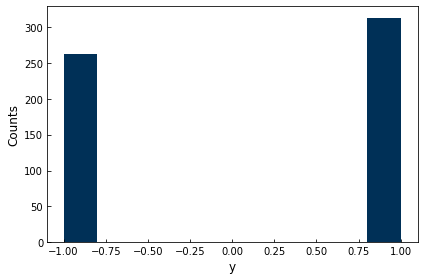

In [5]:
fig, axes = plt.subplots()
axes.hist(y_perov)
axes.set_xlabel('y')
axes.set_ylabel('Counts')
plt.show()

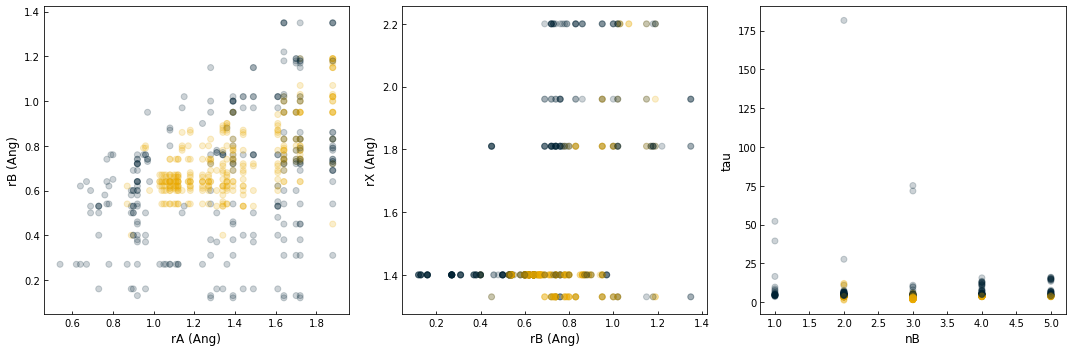

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

axes[0].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_perov], alpha = 0.2)
axes[0].set_xlabel(feature_columns[3])
axes[0].set_ylabel(feature_columns[4])

axes[1].scatter(X_perov[:, 4], X_perov[:, 5], c = clrs[y_perov], alpha = 0.2)
axes[1].set_xlabel(feature_columns[4])
axes[1].set_ylabel(feature_columns[5])

axes[2].scatter(X_perov[:, 1], X_perov[:, 7], c = clrs[y_perov], alpha = 0.2)
axes[2].set_xlabel(feature_columns[1])
axes[2].set_ylabel(feature_columns[7]);

# Kernel-based Models

In [7]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score, confusion_matrix

## RBF Kernel

In [8]:
X_kernel = rbf_kernel(X_perov, X_perov, gamma = 0.02)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


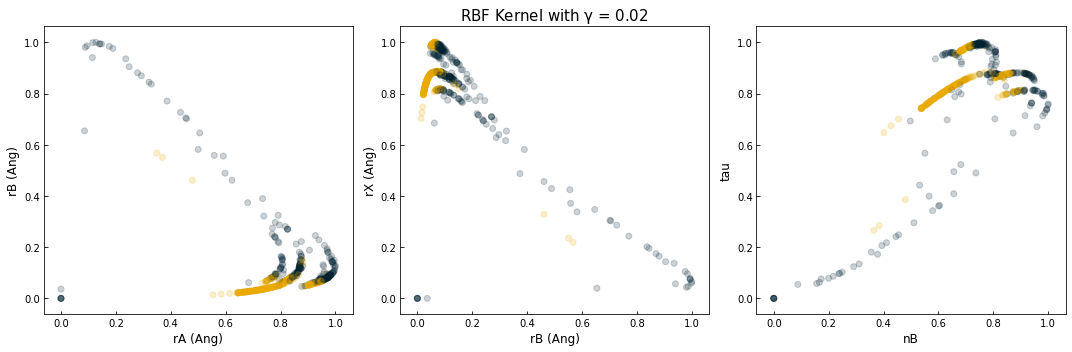

In [9]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))

axes[0].scatter(X_kernel[:, 3], X_kernel[:, 4], c = clrs[y_perov], alpha = 0.2)
axes[0].set_xlabel(feature_columns[3])
axes[0].set_ylabel(feature_columns[4])

axes[1].scatter(X_kernel[:, 4], X_kernel[:, 5], c = clrs[y_perov], alpha = 0.2)
axes[1].set_xlabel(feature_columns[4])
axes[1].set_ylabel(feature_columns[5])

axes[2].scatter(X_kernel[:, 1], X_kernel[:, 7], c = clrs[y_perov], alpha = 0.2)
axes[2].set_xlabel(feature_columns[1])
axes[2].set_ylabel(feature_columns[7])

axes[1].set_title('RBF Kernel with $\gamma$ = 0.02');

## Support vector machine

In [10]:
def add_intercept(X):
    intercept = np.ones((X.shape[0],1))
    X_intercept = np.append(intercept,X,1)
    return X_intercept

In [11]:
def linear_classifier(X, w):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept, w)
    return np.array(p > 0, dtype = int)

In [12]:
def regularized_cost(w, X = X_perov, y = y_perov, alpha = 1):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    cost = sum(np.maximum(0, 1 - y*Xb))
    cost += alpha*np.linalg.norm(w[1:], 2)
    return cost

In [13]:
from scipy.optimize import minimize

## Train SVM with the original data

In [14]:
w_guess = np.array([-10, -4, -10])
result = minimize(regularized_cost, w_guess, args = (X_perov[:, 3:5], y_perov, 1))
w_svm = result.x

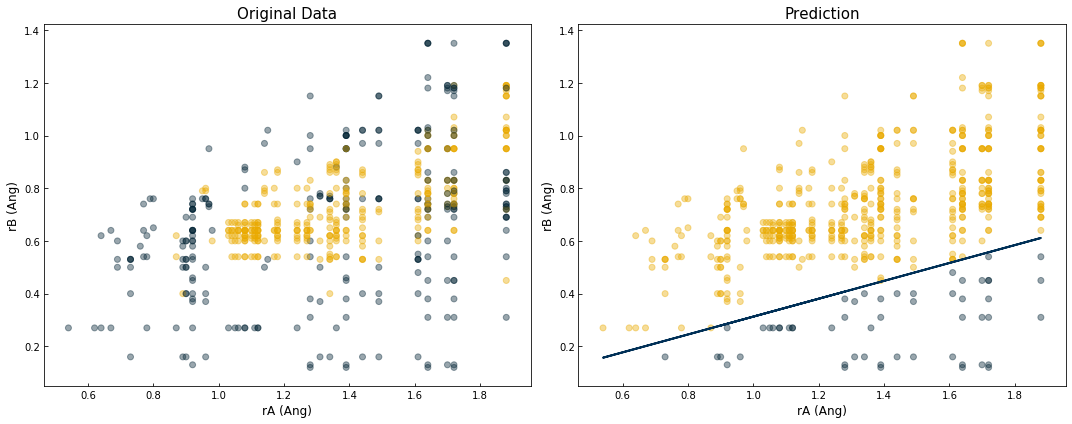

In [15]:
prediction = linear_classifier(X_perov[:, 3:5], w_svm)
prediction = 2 * prediction - 1

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_perov], alpha = .4)
axes[0].set_xlabel(feature_columns[3])
axes[0].set_ylabel(feature_columns[4])

axes[1].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[prediction], alpha = .4)
axes[1].set_xlabel(feature_columns[3])
axes[1].set_ylabel(feature_columns[4])

m = -w_svm[1] / w_svm[2]
b = -w_svm[0] / w_svm[2]
axes[1].plot(X_perov[:, 3], m * X_perov[:, 3] + b, ls = '-')

axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

In [16]:
print(accuracy_score(y_perov, prediction))

0.6302083333333334


## Train SVM after kernel transformation

In [17]:
w_guess = np.array([-10, -4, -10])
result = minimize(regularized_cost, w_guess, args = (X_kernel[:, 3:5], y_perov, 1))
w_svm = result.x

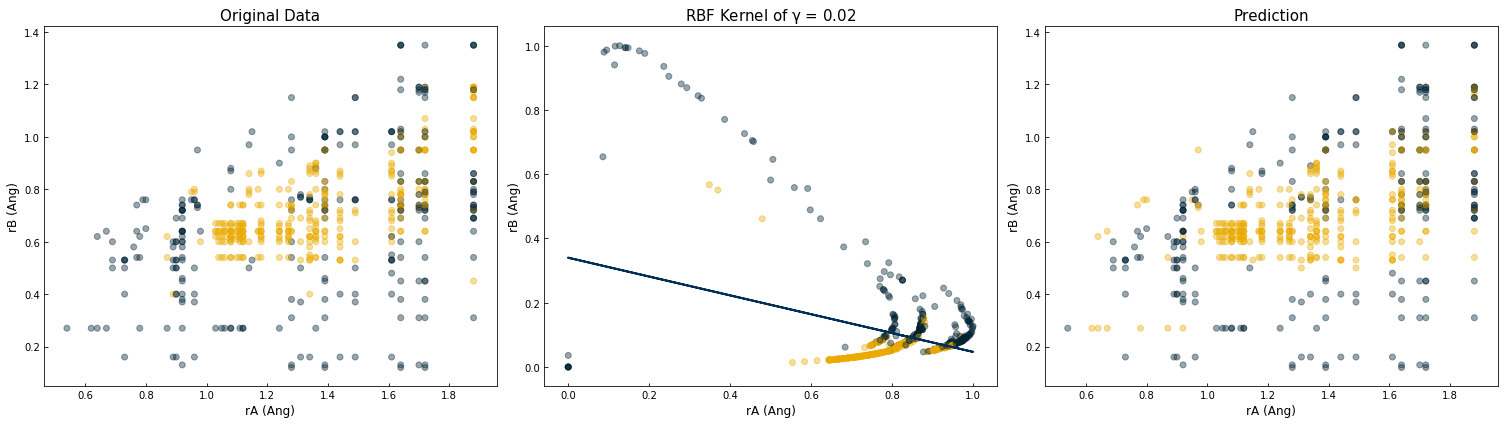

In [18]:
prediction = linear_classifier(X_kernel[:, 3:5], w_svm)
prediction = 2 * prediction - 1

fig, axes = plt.subplots(1, 3, figsize = (21, 6))
axes[0].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_perov], alpha = .4)
axes[0].set_xlabel(feature_columns[3])
axes[0].set_ylabel(feature_columns[4])

axes[1].scatter(X_kernel[:, 3], X_kernel[:, 4], c = clrs[y_perov], alpha = .4)
axes[1].set_xlabel(feature_columns[3])
axes[1].set_ylabel(feature_columns[4])

axes[2].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[prediction], alpha = .4)
axes[2].set_xlabel(feature_columns[3])
axes[2].set_ylabel(feature_columns[4])

m = -w_svm[1] / w_svm[2]
b = -w_svm[0] / w_svm[2]
axes[1].plot(X_kernel[:, 3], m * X_kernel[:, 3] + b, ls = '-')

axes[0].set_title('Original Data')
axes[1].set_title('RBF Kernel of $\gamma$ = 0.02')
axes[2].set_title('Prediction');

In [19]:
print(accuracy_score(y_perov, prediction))

0.8472222222222222


## scikit-learn SVC

In [20]:
from sklearn.svm import SVC

### Use only the 4th & 5th feature

0.9253472222222222


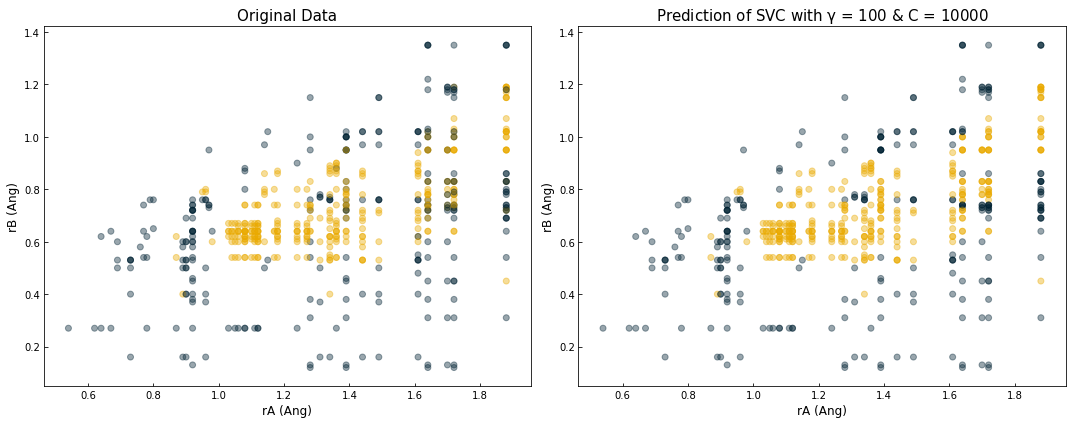

In [21]:
model = SVC(kernel = 'rbf', gamma = 100, C = 1000)
model.fit(X_perov[:, 3:5], y_perov)
y_predict = model.predict(X_perov[:, 3:5])

print(model.score(X_perov[:, 3:5], y_perov))

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_perov], alpha = .4)
axes[0].set_xlabel(feature_columns[3])
axes[0].set_ylabel(feature_columns[4])

axes[1].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_predict], alpha = .4)
axes[1].set_xlabel(feature_columns[3])
axes[1].set_ylabel(feature_columns[4])

axes[0].set_title('Original Data')
axes[1].set_title('Prediction of SVC with $\gamma$ = 100 & C = 10000');

### Use the whole features

0.9965277777777778


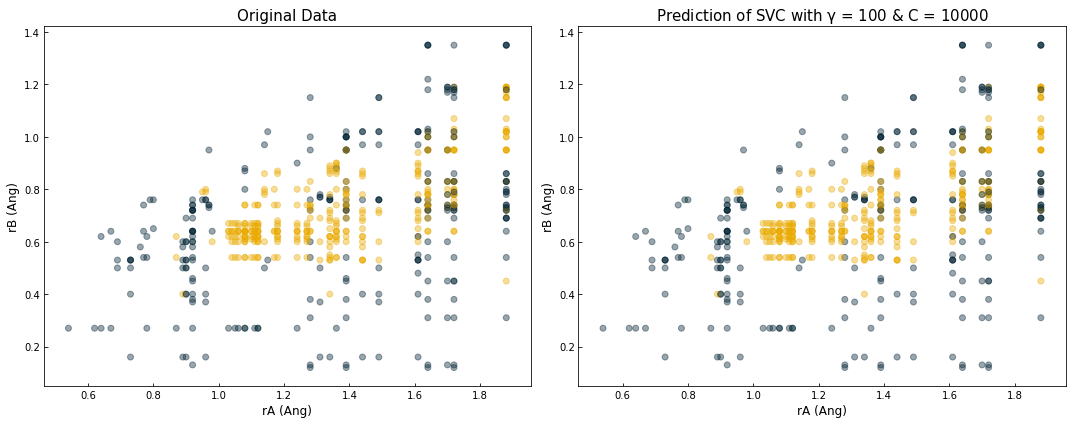

In [22]:
model = SVC(kernel = 'rbf', gamma = 100, C = 1000)
model.fit(X_perov, y_perov)
y_predict = model.predict(X_perov)

print(model.score(X_perov, y_perov))

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_perov], alpha = .4)
axes[0].set_xlabel(feature_columns[3])
axes[0].set_ylabel(feature_columns[4])

axes[1].scatter(X_perov[:, 3], X_perov[:, 4], c = clrs[y_predict], alpha = .4)
axes[1].set_xlabel(feature_columns[3])
axes[1].set_ylabel(feature_columns[4])

axes[0].set_title('Original Data')
axes[1].set_title('Prediction of SVC with $\gamma$ = 100 & C = 10000');

## Comparing Model Performance

We can use a train/test split to check for over-fitting:

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_perov, y_perov, test_size=0.33)

Now, we can work only with the training set to optimize the hyperparameters of the model. Similar to the case of regression, we can take advantage of `GridSearchCV`:

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train) #Shuffle everything just for good measure

sigmas = np.array([1e-3, 1e-2, 1e-1, 1, 10, 100])
gammas = 1. / 2 / sigmas**2

alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
Cs = 1 / alphas

parameter_ranges = {'C': Cs, 'gamma': gammas}

svc = SVC(kernel = 'rbf')

svc_search = GridSearchCV(svc, parameter_ranges, cv = 3)
svc_search.fit(X_train, y_train)
svc_search.best_estimator_, svc_search.best_score_

(SVC(C=100.0, gamma=0.5), 0.9246608527131782)

Let's investigate the performance of this model on the validation set:

In [25]:
best_svc = svc_search.best_estimator_

y_predict = best_svc.predict(X_test)

best_svc.score(X_test, y_test)

0.900523560209424

We see that it works pretty well. We can also visualize the performance using a confusion matrix:

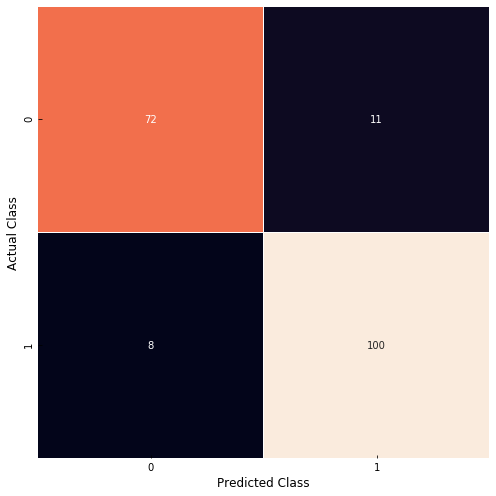

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_predict)

fig, ax = plt.subplots(figsize = (7, 7))
sns.heatmap(cm, annot = True, linewidth = .45, cbar = False, fmt = "d", annot_kws = {'va': 'center'})
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class');

### Exercise: Calculate the accuracy, precision, and recall for the best SVC model on the perovskite dataset.

In [27]:
tn, fp, fn, tp = cm.reshape(-1, )

accuracy = (tn + tp) / (tn + fp + fn + tp)
# precision = ?
# recal = ?

# Decision tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_predict = dtree.predict(X_train)

cm_train = confusion_matrix(y_train, y_predict)

We see that the model performs very well on the training set. However, what we really want to check is the test set:

In [29]:
y_predict = dtree.predict(X_test)
cm_test = confusion_matrix(y_test, y_predict)

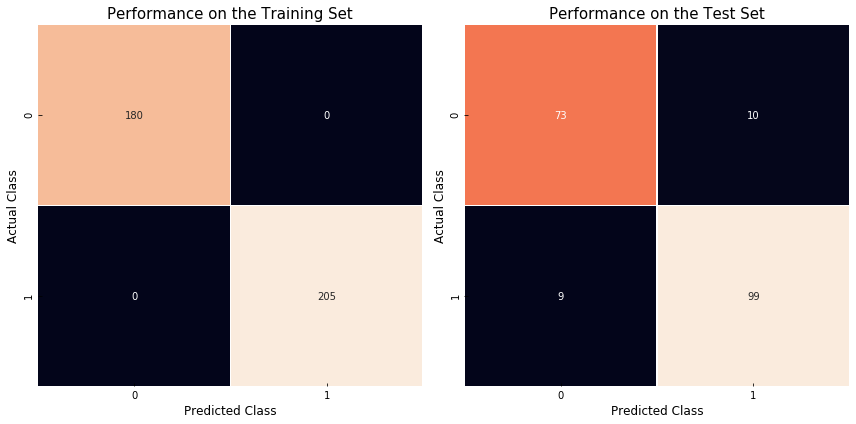

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(cm_train, annot = True, cbar = False, linewidth = .5, ax = axes[0], fmt = 'd', annot_kws = {'va': 'center'})
sns.heatmap(cm_test, annot = True, cbar = False, linewidth = .5, ax = axes[1], fmt = 'd', annot_kws = {'va': 'center'})

axes[0].set_xlabel('Predicted Class')
axes[0].set_ylabel('Actual Class')
axes[0].set_title('Performance on the Training Set')

axes[1].set_xlabel('Predicted Class')
axes[1].set_ylabel('Actual Class')
axes[1].set_title('Performance on the Test Set');

We see that the performance is worse, but not too bad. Let's visualize the model to get some intuition about how it is working:

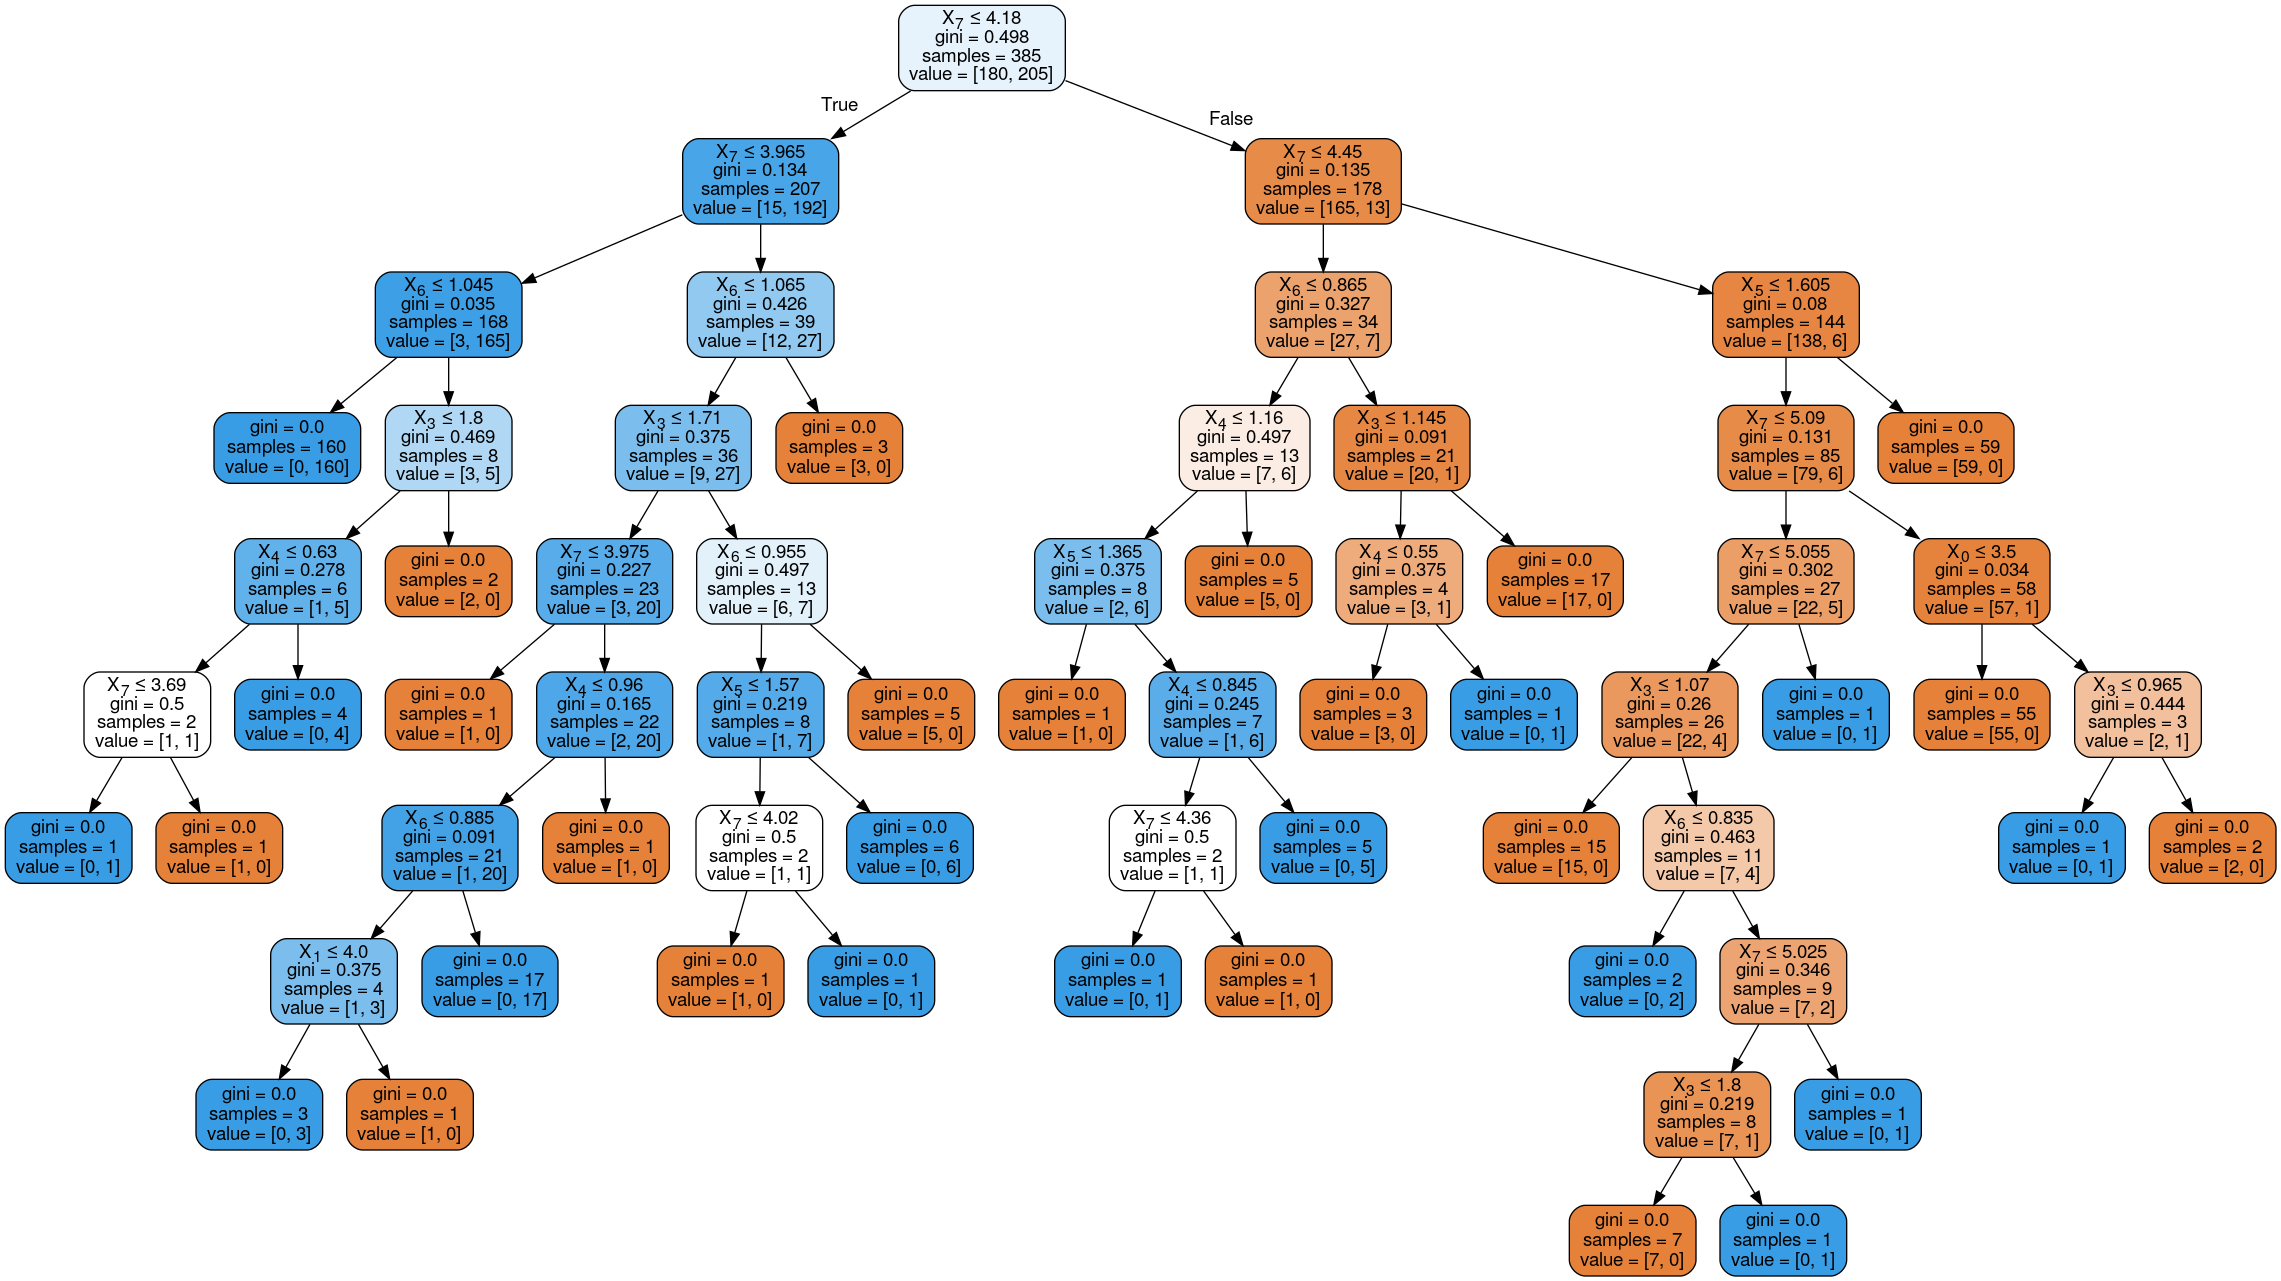

In [31]:
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We see that the tree is very complicated! However, we see that we can "read" the tree and make intuitive sense of how the model works. This is one of the greatest strengths of the decision tree. We can also control the complexity of the tree by limiting its maximum depth:

In [32]:
dtree = DecisionTreeClassifier(max_depth = 3)
dtree.fit(X_train,y_train)
y_predict = dtree.predict(X_train)

cm_train = confusion_matrix(y_train, y_predict)

We see that the training performance is slightly poorer if the max depth is limited. However, the test performance is comparable:

In [33]:
y_predict = dtree.predict(X_test)
cm_test = confusion_matrix(y_test, y_predict)

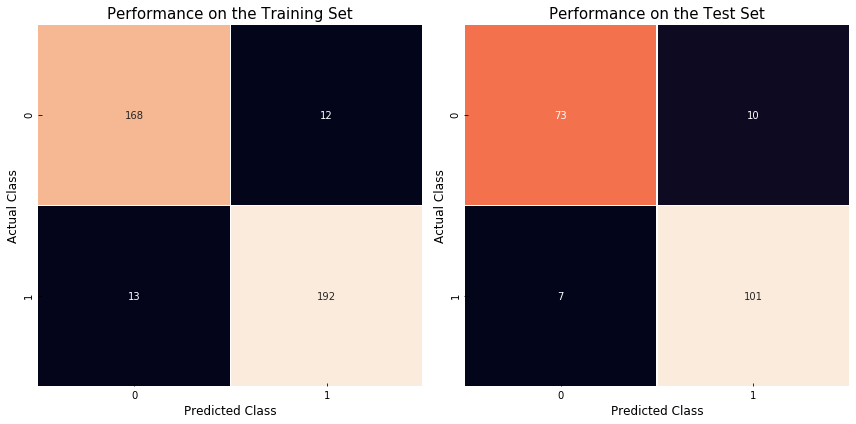

In [34]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(cm_train, annot = True, cbar = False, linewidth = .5, ax = axes[0], fmt = 'd')
sns.heatmap(cm_test, annot = True, cbar = False, linewidth = .5, ax = axes[1], fmt = 'd')

axes[0].set_xlabel('Predicted Class')
axes[0].set_ylabel('Actual Class')
axes[0].set_title('Performance on the Training Set')

axes[1].set_xlabel('Predicted Class')
axes[1].set_ylabel('Actual Class')
axes[1].set_title('Performance on the Test Set');

We can also visualize the tree:

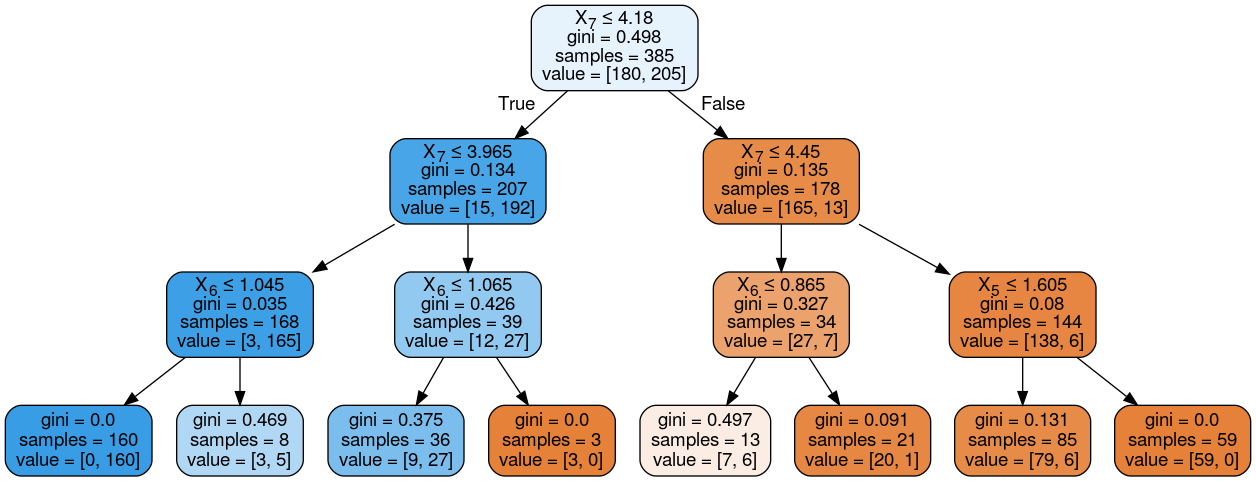

In [35]:
dot_data = StringIO()
export_graphviz(dtree, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Discussion: Which variable is most important for determining whether or not a material will form a perovskite?

> $x_7$ appears the most times in this decision tree.